In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import os

np.random.seed(0)

In [2]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
    use_mps = True
else:
    device = torch.device("cpu")
    use_mps = False

print(device)


mps


In [3]:

class PKLDataset(Dataset):
    def __init__(self, path, transform=None):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.images = data["images"]        # shape: (N, 28, 28, 3)
        self.labels = data["labels"].reshape(-1)   # shape: (N,) instead of (N,1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]             # numpy array (28,28,3)
        label = int(self.labels[idx])      # convert to Python int

        # Convert to tensor and permute to (C, H, W)
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            img = self.transform(img)

        return img, label


In [4]:
import pickle

with open("ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl", "rb") as f:
    data = pickle.load(f)

print(type(data))
print(len(data) if hasattr(data, "__len__") else "no len")
print(data)

<class 'dict'>
2
{'images': array([[[[ 6,  4,  0],
         [ 9,  5,  0],
         [ 8,  4,  0],
         ...,
         [ 9,  6,  0],
         [ 9,  6,  0],
         [ 7,  4,  0]],

        [[11,  6,  0],
         [ 4,  4,  0],
         [ 3,  3,  0],
         ...,
         [ 9,  6,  0],
         [ 6,  4,  0],
         [ 4,  2,  0]],

        [[11,  6,  0],
         [ 4,  4,  0],
         [ 3,  3,  0],
         ...,
         [ 6,  4,  0],
         [ 6,  4,  0],
         [ 4,  2,  0]],

        ...,

        [[ 1,  1,  0],
         [ 0,  0,  0],
         [ 0,  0,  1],
         ...,
         [ 5,  4,  0],
         [ 6,  5,  0],
         [ 6,  5,  0]],

        [[ 3,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  1],
         ...,
         [ 6,  5,  0],
         [ 6,  5,  0],
         [ 7,  6,  0]],

        [[10,  2,  2],
         [ 0,  0,  1],
         [ 0,  0,  1],
         ...,
         [ 6,  5,  0],
         [ 7,  6,  0],
         [ 7,  6,  0]]],


       [[[11,  9,  0],
         

In [5]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Subset



dataset = PKLDataset("ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl",)


loader = DataLoader(dataset, batch_size=64, shuffle=False)

d_mean = torch.zeros(3)
d_std = torch.zeros(3)
nb_samples = 0.0

for images, _ in loader:
    batch_samples = images.size(0)

    d_mean += images.mean(dim=[0,2,3]) * batch_samples
    d_std += images.std(dim=[0,2,3]) * batch_samples
    nb_samples += batch_samples

d_mean /= nb_samples
d_std /= nb_samples

d_mean = d_mean.tolist()
d_std = d_std.tolist()

print("Mean:", d_mean)
print("Std:", d_std)



Mean: [0.21014535427093506, 0.005330359563231468, 0.2285669893026352]
Std: [0.18871904909610748, 0.01642582379281521, 0.16962255537509918]


In [6]:
# Définir les transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.RandomRotation(25),

    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),        # La rotation est cruciale pour l'œil
    transforms.Normalize(mean=d_mean, std=d_std),
])

transform_val = transforms.Compose([
   # transforms.Normalize(mean=d_mean, std=d_std),
])

In [7]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.subset)

In [8]:
from torch.utils.data import WeightedRandomSampler
import torch
import numpy as np

# 1. Votre Split existant (inchangé)
labels = dataset.labels
indices = np.arange(len(dataset))
train_idx, valid_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# 2. Préparation du Sampler (NOUVEAU BLOC)
# On récupère uniquement les labels qui sont dans le set d'entrainement
y_train = labels[train_idx].reshape(-1) # reshape pour être sûr d'avoir (N,) et pas (N,1)

# Compter combien d'exemples il y a par classe dans le train
class_counts = np.bincount(y_train)

class_weights = 1. / class_counts

samples_weights = class_weights[y_train]
samples_weights = torch.from_numpy(samples_weights).double()

# Créer le sampler
sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True # CRUCIAL : permet de re-piocher les images rares plusieurs fois par epoch
)

train_data = Subset(dataset, train_idx)
valid_data = Subset(dataset, valid_idx)

train_data = TransformSubset(train_data, transform=transform_train)
valid_data = TransformSubset(valid_data, transform=transform_val)

train_loader = DataLoader(
    train_data, 
    batch_size=64, 
    #sampler=sampler, 
    shuffle=True   
)

# Le valid_loader reste classique (on ne veut pas de sampler pour la validation)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

In [9]:
import numpy as np

labels = dataset.labels
classes, counts = np.unique(labels, return_counts=True)

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

test_loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [10]:
def train(model, train_loader, optimizer, epoch):
    """Perform one epoch of training."""
    model.train()

    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)

        # 1) Reset gradients
        optimizer.zero_grad()

        # 2) Forward pass
        output = model(inputs)

        # 3) Compute loss
        loss = loss_fn(output, target)

        # 4) Backpropagation
        loss.backward()

        # 5) Update weights
        optimizer.step()

        # Logging
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(inputs),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))


In [11]:
from sklearn.metrics import recall_score

def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()

    test_loss = 0   # total loss over test set
    correct = 0     # total number of correct test predictions
    test_size = 0   # number of test samples used
    all_preds = []  # to store all predictions
    all_targets = []# to store all targets

    with torch.no_grad():  # no backprop, faster evaluation
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)

            # Forward pass
            output = model(inputs)

            # Accumulate loss (sum, not mean)
            loss = test_loss_fn(output, target)  # already reduction='sum'
            test_loss += loss.item()

            # Predictions
            pred = output.argmax(dim=1)  # index of highest logit

            all_preds.extend(pred.tolist())
            all_targets.extend(target.tolist()) # Target est déjà long pour CrossEntropy

            correct += (pred == target).sum().item()

            # Keep track of sample count
            test_size += target.size(0)

    # Final metrics
    test_loss /= test_size
    accuracy = correct / test_size

    macro_recall = recall_score(
        all_targets, 
        all_preds, 
        average='macro', 
        zero_division=0
    )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size, 100. * accuracy))

    return test_loss, accuracy, macro_recall, all_preds, all_targets


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  
            nn.Dropout(0.40)
        )

        # Dense
        self.fc1 = nn.Linear(64, 32)
        self.dropout_fc = nn.Dropout(0.40)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x




In [13]:
subset = Subset(train_data, list(range(50)))
subset_loader = DataLoader(subset, batch_size=10, shuffle=False)
model = CNNNet().to(device)
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

for epoch in range(50):
    train(model, subset_loader, optimizer, epoch)
    loss, acc, _, _, _ = test(model, subset_loader)
    print(loss, acc)


Train Epoch: 0 [0/50 (0%)]	Loss: 1.583301
Test set: Average loss: 1.4791, Accuracy: 11/50 (22%)

1.4790935897827149 0.22
Train Epoch: 1 [0/50 (0%)]	Loss: 1.574026
Test set: Average loss: 1.4747, Accuracy: 10/50 (20%)

1.4747462844848633 0.2
Train Epoch: 2 [0/50 (0%)]	Loss: 1.642532
Test set: Average loss: 1.4728, Accuracy: 9/50 (18%)

1.4727666854858399 0.18
Train Epoch: 3 [0/50 (0%)]	Loss: 1.593401
Test set: Average loss: 1.4707, Accuracy: 9/50 (18%)

1.47068603515625 0.18
Train Epoch: 4 [0/50 (0%)]	Loss: 1.588622
Test set: Average loss: 1.4660, Accuracy: 10/50 (20%)

1.4659762954711915 0.2
Train Epoch: 5 [0/50 (0%)]	Loss: 1.668492
Test set: Average loss: 1.4680, Accuracy: 10/50 (20%)

1.4679867553710937 0.2
Train Epoch: 6 [0/50 (0%)]	Loss: 1.624173
Test set: Average loss: 1.4630, Accuracy: 13/50 (26%)

1.4629621505737305 0.26
Train Epoch: 7 [0/50 (0%)]	Loss: 1.573035
Test set: Average loss: 1.4662, Accuracy: 10/50 (20%)

1.466217384338379 0.2
Train Epoch: 8 [0/50 (0%)]	Loss: 1.542495

In [14]:
model = CNNNet().to(device)
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode='max', factor=0.5, patience=4
)
results = {'name':'model', 'lr': lr, 'train_loss': [],
'train_acc': [],
'val_loss': [],
'val_acc': [],
'val_macro_recall': [],
'final_val_preds': [],
'final_val_targets': []
}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    train_loss, train_acc, _, _, _= test(model, train_loader)


    val_loss, val_acc, val_macro_recall, final_val_preds, final_val_targets = test(model, valid_loader)

    scheduler.step(val_acc)
    
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['val_macro_recall'].append(val_macro_recall)

    if epoch == 49:
        results['final_val_preds'] = final_val_preds
        results['final_val_targets'] = final_val_targets

    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/864 (0%)]	Loss: 1.626641
Train Epoch: 1 [640/864 (71%)]	Loss: 1.635806
Test set: Average loss: 1.5985, Accuracy: 268/864 (31%)

Test set: Average loss: 1.6105, Accuracy: 41/216 (19%)

Train Epoch: 2 [0/864 (0%)]	Loss: 1.588695
Train Epoch: 2 [640/864 (71%)]	Loss: 1.615764
Test set: Average loss: 1.5806, Accuracy: 220/864 (25%)

Test set: Average loss: 1.6108, Accuracy: 26/216 (12%)

Train Epoch: 3 [0/864 (0%)]	Loss: 1.612537
Train Epoch: 3 [640/864 (71%)]	Loss: 1.528924
Test set: Average loss: 1.5709, Accuracy: 265/864 (31%)

Test set: Average loss: 1.6061, Accuracy: 24/216 (11%)

Train Epoch: 4 [0/864 (0%)]	Loss: 1.558726
Train Epoch: 4 [640/864 (71%)]	Loss: 1.611751
Test set: Average loss: 1.5583, Accuracy: 263/864 (30%)

Test set: Average loss: 1.6032, Accuracy: 21/216 (10%)

Train Epoch: 5 [0/864 (0%)]	Loss: 1.548557
Train Epoch: 5 [640/864 (71%)]	Loss: 1.585473
Test set: Average loss: 1.5686, Accuracy: 265/864 (31%)

Test set: Average loss: 1.6051, Accuracy: 15/2

Last results keys: dict_keys(['name', 'lr', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_macro_recall', 'final_val_preds', 'final_val_targets'])


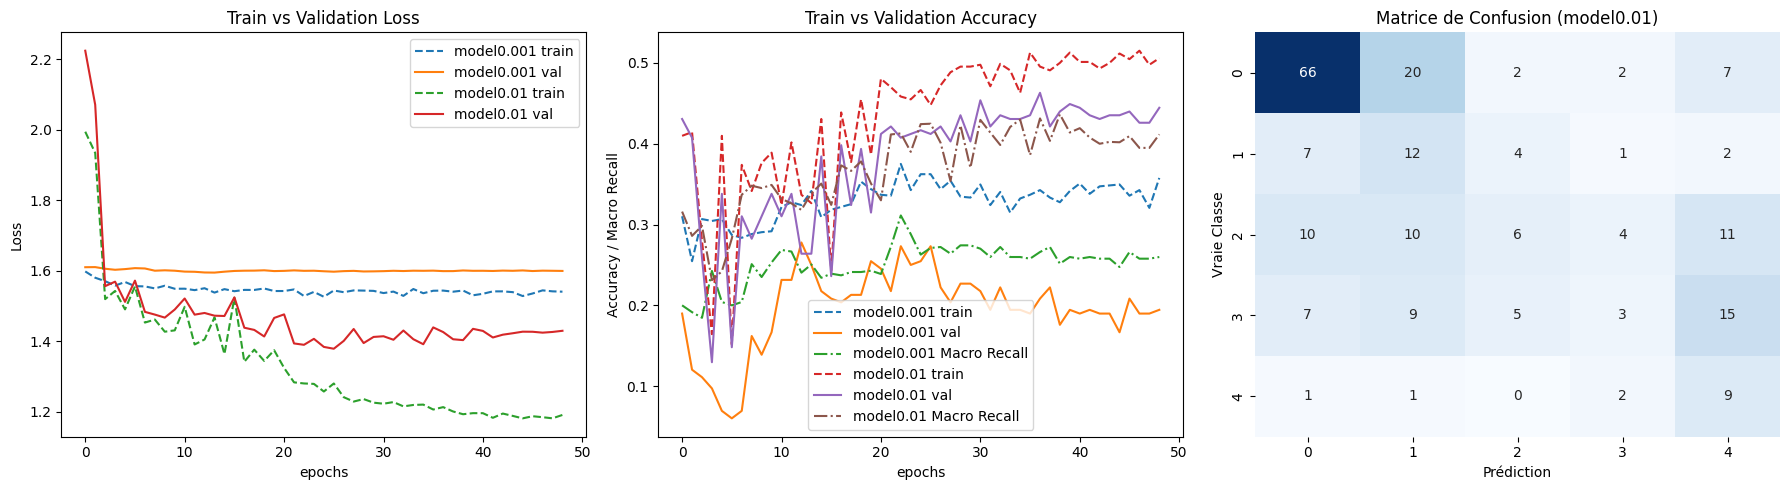

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Liste pour stocker les résultats du dernier modèle chargé
last_results = None 
last_label = None

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename), 'rb') as fin:
            results = pickle.load(fin)
            label = filename[:-4]  # nom sans .pkl
            last_results = results
            last_label = label
            
            # --- Courbes de LOSS (ax1) ---
            ax1.plot(results['train_loss'], '--', label=f'{label} train')
            ax1.plot(results['val_loss'], '-',  label=f'{label} val')
            ax1.set_ylabel('Loss') 
            ax1.set_xlabel('epochs')
            ax1.set_title('Train vs Validation Loss')

            ax2.plot(results['train_acc'], '--', label=f'{label} train')
            ax2.plot(results['val_acc'], '-',  label=f'{label} val')
            
            if 'val_macro_recall' in results:
                 ax2.plot(results['val_macro_recall'], '-.', label=f'{label} Macro Recall') 
                 
            ax2.set_ylabel('Accuracy / Macro Recall')
            ax2.set_xlabel('epochs')
            ax2.set_title('Train vs Validation Accuracy')

print("Last results keys:", last_results.keys() if last_results else "No results loaded")

if last_results and 'final_val_preds' in last_results:
    y_true = np.array(last_results['final_val_targets'])
    y_pred = np.array(last_results['final_val_preds'])
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Affichage de la Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False)
    ax3.set_title(f'Matrice de Confusion ({last_label})')
    ax3.set_xlabel('Prédiction')
    ax3.set_ylabel('Vraie Classe')
    
# Légende pour ax1 et ax2
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.show()